<a href="https://colab.research.google.com/github/hapticPaper/PythonInstructional/blob/master/MIT_Intro_to_Deep_Learning_CNN_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="https://i.ibb.co/Jr88sn2/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/github/aamini/introtodeeplearning/blob/2023/lab2/Part1_MNIST.ipynb">
        <img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/aamini/introtodeeplearning/blob/2023/lab2/Part1_MNIST.ipynb">
        <img src="https://i.ibb.co/xfJbPmL/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>

# Copyright Information

In [1]:
# Copyright 2023 MIT Introduction to Deep Learning. All Rights Reserved.
#
# Licensed under the MIT License. You may not use this file except in compliance
# with the License. Use and/or modification of this code outside of MIT Introduction
# to Deep Learning must reference:
#
# © MIT Introduction to Deep Learning
# http://introtodeeplearning.com
#

# Laboratory 2: Computer Vision

# Part 1: MNIST Digit Classification

In the first portion of this lab, we will build and train a convolutional neural network (CNN) for classification of handwritten digits from the famous [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. The MNIST dataset consists of 60,000 training images and 10,000 test images. Our classes are the digits 0-9.

First, let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

In [1]:
# Import Tensorflow 2.0
import tensorflow as tf
import tensorboard
import keras

!pip install mitdeeplearning
import mitdeeplearning as mdl

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from datetime import datetime, time
import os

# Check that we are using a GPU, if not switch runtimes
#   using Runtime > Change Runtime Type > GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

Looking in indexes: https://pypi.org/simple/


AssertionError: 

## 1.1 MNIST dataset

Let's download and load the dataset and display a few random samples from it:

In [2]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = (np.expand_dims(train_images, axis=-1)/255.).astype(np.float32)
train_labels = (train_labels).astype(np.int64)
test_images = (np.expand_dims(test_images, axis=-1)/255.).astype(np.float32)
test_labels = (test_labels).astype(np.int64)

Our training set is made up of 28x28 grayscale images of handwritten digits.

Let's visualize what some of these images and their corresponding training labels look like.

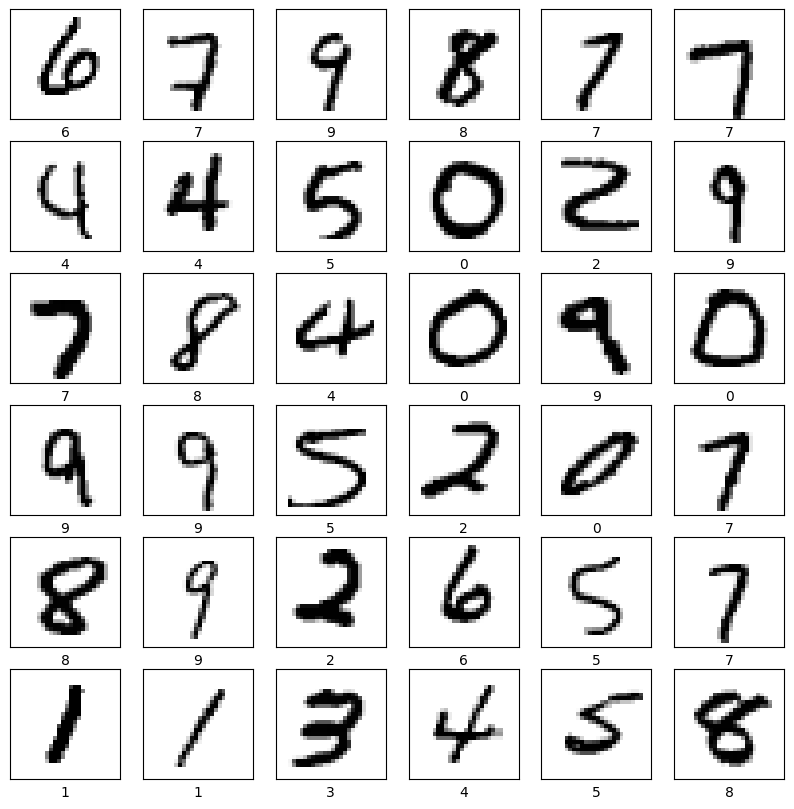

In [3]:
plt.figure(figsize=(10,10))
random_inds = np.random.choice(60000,36)
for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    plt.imshow(np.squeeze(train_images[image_ind]), cmap=plt.cm.binary)
    plt.xlabel(train_labels[image_ind])

## 1.2 Neural Network for Handwritten Digit Classification

We'll first build a simple neural network consisting of two fully connected layers and apply this to the digit classification task. Our network will ultimately output a probability distribution over the 10 digit classes (0-9). This first architecture we will be building is depicted below:

![alt_text](https://raw.githubusercontent.com/aamini/introtodeeplearning/master/lab2/img/mnist_2layers_arch.png "CNN Architecture for MNIST Classification")


### Fully connected neural network architecture
To define the architecture of this first fully connected neural network, we'll once again use the Keras API and define the model using the [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential) class. Note how we first use a [`Flatten`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) layer, which flattens the input so that it can be fed into the model.

In this next block, you'll define the fully connected layers of this simple work.

In [5]:
checkpoint_path = "mnist_training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)


In [6]:
def build_fc_model():
  fc_model = tf.keras.Sequential([
      # First define a Flatten layer
      tf.keras.layers.Flatten(),

      #'''TODO: Define the activation function for the first fully connected (Dense) layer.'''
      tf.keras.layers.Dense(128, activation="relu"),


      # '''TODO: Define the second Dense layer to output the classification probabilities'''
      ##'''TODO: Dense layer to output classification probabilities'''
      tf.keras.layers.Dense(units=10, activation='softmax')
  ])
  return fc_model

model = build_fc_model()

As we progress through this next portion, you may find that you'll want to make changes to the architecture defined above. **Note that in order to update the model later on, you'll need to re-run the above cell to re-initialize the model.**

Let's take a step back and think about the network we've just created. The first layer in this network, `tf.keras.layers.Flatten`, transforms the format of the images from a 2d-array (28 x 28 pixels), to a 1d-array of 28 * 28 = 784 pixels. You can think of this layer as unstacking rows of pixels in the image and lining them up. There are no learned parameters in this layer; it only reformats the data.

After the pixels are flattened, the network consists of a sequence of two `tf.keras.layers.Dense` layers. These are fully-connected neural layers. The first `Dense` layer has 128 nodes (or neurons). The second (and last) layer (which you've defined!) should return an array of probability scores that sum to 1. Each node contains a score that indicates the probability that the current image belongs to one of the handwritten digit classes.

That defines our fully connected model!



### Compile the model

Before training the model, we need to define a few more settings. These are added during the model's [`compile`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#compile) step:

* *Loss function* — This defines how we measure how accurate the model is during training. As was covered in lecture, during training we want to minimize this function, which will "steer" the model in the right direction.
* *Optimizer* — This defines how the model is updated based on the data it sees and its loss function.
* *Metrics* — Here we can define metrics used to monitor the training and testing steps. In this example, we'll look at the *accuracy*, the fraction of the images that are correctly classified.

We'll start out by using a stochastic gradient descent (SGD) optimizer initialized with a learning rate of 0.1. Since we are performing a categorical classification task, we'll want to use the [cross entropy loss](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/sparse_categorical_crossentropy).

You'll want to experiment with both the choice of optimizer and learning rate and evaluate how these affect the accuracy of the trained model.

In [7]:
'''TODO: Experiment with different optimizers and learning rates. How do these affect
    the accuracy of the trained model? Which optimizers and/or learning rates yield
    the best performance?'''
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2, weight_decay=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train the model

We're now ready to train our model, which will involve feeding the training data (`train_images` and `train_labels`) into the model, and then asking it to learn the associations between images and labels. We'll also need to define the batch size and the number of epochs, or iterations over the MNIST dataset, to use during training.

In Lab 1, we saw how we can use `GradientTape` to optimize losses and train models with stochastic gradient descent. After defining the model settings in the `compile` step, we can also accomplish training by calling the [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#fit) method on an instance of the `Model` class. We will use this to train our fully connected model


In [5]:
def persist_model(checkpoint_path, logdir):
    checkpoint_path = checkpoint_path
    checkpoint_dir = os.path.dirname(checkpoint_path)

    logdir = logdir + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                    save_weights_only=False,
                                                    verbose=1)
    return cp_callback, tensorboard_callback

@tf.function
def serve(*args, **kwargs):
  outputs = model(*args, **kwargs)
  # Apply postprocessing steps, or add additional outputs.
  ...
  return outputs

In [9]:
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 128
EPOCHS = 25
model_directory = "mnist_training"
logs = os.path.join(model_directory, 'logs')


try:
    loaded_model = tf.keras.models.model.load_model(model_directory)
except Exception as e:
    pass

cp_callback, tensorboard_callback = persist_model(model_directory, logs)

model.fit(train_images, train_labels,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[cp_callback, tensorboard_callback]
          )
try:

    arg_specs, kwarg_specs = model.save_spec()
    model.save(checkpoint_path, signatures={
    'serving_default': serve.get_concrete_function(*arg_specs,
                                                    **kwarg_specs)
    })
except Exception as e:
    pass

Epoch 1/25
451/469 [===========================>..] - ETA: 0s - loss: 0.2209 - accuracy: 0.9337
Epoch 1: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.2174 - accuracy: 0.9346
Epoch 2/25
450/469 [===========================>..] - ETA: 0s - loss: 0.1093 - accuracy: 0.9675
Epoch 2: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.1097 - accuracy: 0.9673
Epoch 3/25
447/469 [===========================>..] - ETA: 0s - loss: 0.0875 - accuracy: 0.9730
Epoch 3: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0875 - accuracy: 0.9729
Epoch 4/25
447/469 [===========================>..] - ETA: 0s - loss: 0.0740 - accuracy: 0.9773
Epoch 4: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0752 - accuracy: 0.9770
Epoch 5/25
448/469 [===========================>..] - ETA: 0s - loss: 0.0712 - accuracy: 0.9785
Epoch 5: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0713 - accuracy: 0.9785
Epoch 6/25
435/469 [==========================>...] - ETA: 0s - loss: 0.0568 - accuracy: 0.9826
Epoch 6: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0580 - accuracy: 0.9824
Epoch 7/25
458/469 [============================>.] - ETA: 0s - loss: 0.0559 - accuracy: 0.9830
Epoch 7: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0559 - accuracy: 0.9830
Epoch 8/25
430/469 [==========================>...] - ETA: 0s - loss: 0.0557 - accuracy: 0.9840
Epoch 8: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 2ms/step - loss: 0.0562 - accuracy: 0.9839
Epoch 9/25
438/469 [===========================>..] - ETA: 0s - loss: 0.0502 - accuracy: 0.9851
Epoch 9: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0502 - accuracy: 0.9851
Epoch 10/25
443/469 [===========================>..] - ETA: 0s - loss: 0.0489 - accuracy: 0.9859
Epoch 10: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0507 - accuracy: 0.9854
Epoch 11/25
437/469 [==========================>...] - ETA: 0s - loss: 0.0446 - accuracy: 0.9879
Epoch 11: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0455 - accuracy: 0.9877
Epoch 12/25
444/469 [===========================>..] - ETA: 0s - loss: 0.0472 - accuracy: 0.9875
Epoch 12: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0485 - accuracy: 0.9872
Epoch 13/25
443/469 [===========================>..] - ETA: 0s - loss: 0.0461 - accuracy: 0.9884
Epoch 13: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0466 - accuracy: 0.9883
Epoch 14/25
442/469 [===========================>..] - ETA: 0s - loss: 0.0389 - accuracy: 0.9896
Epoch 14: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0401 - accuracy: 0.9894
Epoch 15/25
445/469 [===========================>..] - ETA: 0s - loss: 0.0412 - accuracy: 0.9896
Epoch 15: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0419 - accuracy: 0.9894
Epoch 16/25
448/469 [===========================>..] - ETA: 0s - loss: 0.0408 - accuracy: 0.9898
Epoch 16: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0403 - accuracy: 0.9899
Epoch 17/25
451/469 [===========================>..] - ETA: 0s - loss: 0.0354 - accuracy: 0.9912
Epoch 17: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0350 - accuracy: 0.9912
Epoch 18/25
445/469 [===========================>..] - ETA: 0s - loss: 0.0385 - accuracy: 0.9913
Epoch 18: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0384 - accuracy: 0.9912
Epoch 19/25
432/469 [==========================>...] - ETA: 0s - loss: 0.0387 - accuracy: 0.9909
Epoch 19: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0409 - accuracy: 0.9905
Epoch 20/25
443/469 [===========================>..] - ETA: 0s - loss: 0.0440 - accuracy: 0.9903
Epoch 20: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0440 - accuracy: 0.9905
Epoch 21/25
443/469 [===========================>..] - ETA: 0s - loss: 0.0380 - accuracy: 0.9914
Epoch 21: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0385 - accuracy: 0.9913
Epoch 22/25
443/469 [===========================>..] - ETA: 0s - loss: 0.0334 - accuracy: 0.9924
Epoch 22: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0337 - accuracy: 0.9923
Epoch 23/25
449/469 [===========================>..] - ETA: 0s - loss: 0.0342 - accuracy: 0.9924
Epoch 23: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0344 - accuracy: 0.9925
Epoch 24/25
446/469 [===========================>..] - ETA: 0s - loss: 0.0295 - accuracy: 0.9934
Epoch 24: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0296 - accuracy: 0.9933
Epoch 25/25
445/469 [===========================>..] - ETA: 0s - loss: 0.0356 - accuracy: 0.9926
Epoch 25: saving model to mnist_training
INFO:tensorflow:Assets written to: mnist_training/assets


INFO:tensorflow:Assets written to: mnist_training/assets


469/469 [==============================] - 1s 1ms/step - loss: 0.0353 - accuracy: 0.9926
INFO:tensorflow:Assets written to: mnist_training/cp.ckpt/assets


INFO:tensorflow:Assets written to: mnist_training/cp.ckpt/assets


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
!tensorboard --logdir 'logs/scalars' --port 8080

2023-12-28 00:06:17.595953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-28 00:06:17.596012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-28 00:06:17.597515: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-28 00:06:18.641318: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

E1228 00:06:20.501067 138327829336064 program.p

As the model trains, the loss and accuracy metrics are displayed. With five epochs and a learning rate of 0.01, this fully connected model should achieve an accuracy of approximatley 0.97 (or 97%) on the training data.

### Evaluate accuracy on the test dataset

Now that we've trained the model, we can ask it to make predictions about a test set that it hasn't seen before. In this example, the `test_images` array comprises our test dataset. To evaluate accuracy, we can check to see if the model's predictions match the labels from the `test_labels` array.

Use the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate) method to evaluate the model on the test dataset!

In [10]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = model.evaluate(
    x=test_images,
    y=test_labels,
    batch_size=10,
    verbose='auto',
)

print('Test accuracy:', test_acc)

1000/1000 [==============================] - 0s 331us/step - loss: 0.2890 - accuracy: 0.9759
Test accuracy: 0.9758999943733215


You may observe that the accuracy on the test dataset is a little lower than the accuracy on the training dataset. This gap between training accuracy and test accuracy is an example of *overfitting*, when a machine learning model performs worse on new data than on its training data.

What is the highest accuracy you can achieve with this first fully connected model? Since the handwritten digit classification task is pretty straightforward, you may be wondering how we can do better...

![Deeper...](https://i.kym-cdn.com/photos/images/newsfeed/000/534/153/f87.jpg)

## 1.3 Convolutional Neural Network (CNN) for handwritten digit classification

As we saw in lecture, convolutional neural networks (CNNs) are particularly well-suited for a variety of tasks in computer vision, and have achieved near-perfect accuracies on the MNIST dataset. We will now build a CNN composed of two convolutional layers and pooling layers, followed by two fully connected layers, and ultimately output a probability distribution over the 10 digit classes (0-9). The CNN we will be building is depicted below:

![alt_text](https://raw.githubusercontent.com/aamini/introtodeeplearning/master/lab2/img/convnet_fig.png "CNN Architecture for MNIST Classification")

### Define the CNN model

We'll use the same training and test datasets as before, and proceed similarly as our fully connected network to define and train our new CNN model. To do this we will explore two layers we have not encountered before: you can use  [`keras.layers.Conv2D` ](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) to define convolutional layers and [`keras.layers.MaxPool2D`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) to define the pooling layers. Use the parameters shown in the network architecture above to define these layers and build the CNN model.

In [6]:


model_directory = "mnist_cnn_training/"
logs = os.path.join(model_directory, 'logs')
cp_callback, tensorboard_callback = persist_model(model_directory, logs)

def build_cnn_model():
    cnn_model = tf.keras.Sequential([

        # TODO: Define the first convolutional layer
        tf.keras.layers.Conv2D(filters = 24,  kernel_size = (3,3), padding='valid', activation="relu"),

        # TODO: Define the first max pooling layer
        tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2),  data_format='channels_last'),

        # TODO: Define the second convolutional layer
        tf.keras.layers.Conv2D(filters = 36,  kernel_size = (3,3),  activation="relu"),

        # TODO: Define the second max pooling layer
        tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = (2,2),  data_format='channels_last'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),

        # TODO: Define the last Dense layer to output the classification
        # probabilities. Pay attention to the activation needed a probability
        # output
        tf.keras.layers.Dense(units=10, activation='softmax'),

    ])

    return cnn_model

cnn_model = build_cnn_model()
# Initialize the model by passing some data through
cnn_model.predict(train_images[[0]])
# Print the summary of the layers in the model.
print(cnn_model.summary())

1/1 [==============================] - 0s 64ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 24)        240       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 24)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 36)        7812      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 36)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 900)               0         
                                                                 
 den

### Train and test the CNN model

Now, as before, we can define the loss function, optimizer, and metrics through the `compile` method. Compile the CNN model with an optimizer and learning rate of choice:

In [7]:
'''TODO: Define the compile operation with your optimizer and learning rate of choice'''
cnn_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-3),
                    loss=tf.keras.losses.sparse_categorical_crossentropy,
                    metrics=['accuracy']   )

As was the case with the fully connected model, we can train our CNN using the `fit` method via the Keras API.

In [137]:
'''TODO: Use model.fit to train the CNN model, with the same batch_size and number of epochs previously used.'''
# Define the batch size and the number of epochs to use during training
BATCH_SIZE = 128
EPOCHS = 1



cnn_model.fit(train_images, train_labels,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          callbacks=[cp_callback, tensorboard_callback]
          )
try:

    arg_specs, kwarg_specs = model.save_spec()
    model.save(checkpoint_path, signatures={
    'serving_default': serve.get_concrete_function(*arg_specs,
                                                    **kwarg_specs)
    })
except Exception as e:
    pass

467/469 [============================>.] - ETA: 0s - loss: 0.2334 - accuracy: 0.9325
Epoch 1: saving model to mnist_acnn/
INFO:tensorflow:Assets written to: mnist_acnn/assets


INFO:tensorflow:Assets written to: mnist_acnn/assets


469/469 [==============================] - 3s 7ms/step - loss: 0.2329 - accuracy: 0.9326
INFO:tensorflow:Assets written to: mnist_training/cp.ckpt/assets


INFO:tensorflow:Assets written to: mnist_training/cp.ckpt/assets


Great! Now that we've trained the model, let's evaluate it on the test dataset using the [`evaluate`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#evaluate) method:

In [138]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

313/313 [==============================] - 0s 1ms/step - loss: 0.0697 - accuracy: 0.9787
Test accuracy: 0.9786999821662903


What is the highest accuracy you're able to achieve using the CNN model, and how does the accuracy of the CNN model compare to the accuracy of the simple fully connected network? What optimizers and learning rates seem to be optimal for training the CNN model?

### Make predictions with the CNN model

With the model trained, we can use it to make predictions about some images. The [`predict`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#predict) function call generates the output predictions given a set of input samples.


In [17]:
predictions = cnn_model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


With this function call, the model has predicted the label for each image in the testing set. Let's take a look at the prediction for the first image in the test dataset:

In [18]:
predictions[0]

array([3.8425695e-16, 2.4560065e-15, 2.8490762e-12, 1.2846671e-15,
       1.0315320e-13, 1.0273431e-18, 3.0875813e-30, 1.0000000e+00,
       6.4906097e-17, 4.7354131e-15], dtype=float32)

As you can see, a prediction is an array of 10 numbers. Recall that the output of our model is a probability distribution over the 10 digit classes. Thus, these numbers describe the model's "confidence" that the image corresponds to each of the 10 different digits.

Let's look at the digit that has the highest confidence for the first image in the test dataset:

In [19]:
'''TODO: identify the digit with the highest confidence prediction for the first
    image in the test dataset. '''
prediction = 7
print(prediction)

7


So, the model is most confident that this image is a "???". We can check the test label (remember, this is the true identity of the digit) to see if this prediction is correct:

Label of this digit is: 7


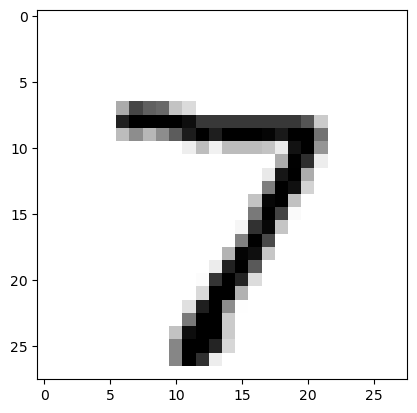

In [139]:
print("Label of this digit is:", test_labels[0])
plt.imshow(test_images[0,:,:,0], cmap=plt.cm.binary)

It is! Let's visualize the classification results on the MNIST dataset. We will plot images from the test dataset along with their predicted label, as well as a histogram that provides the prediction probabilities for each of the digits:

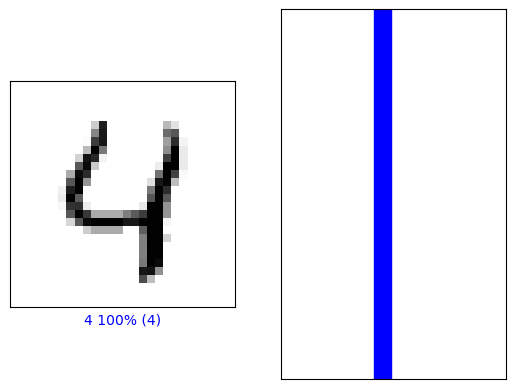

In [21]:
#@title Change the slider to look at the model's predictions! { run: "auto" }

image_index = 4 #@param {type:"slider", min:0, max:100, step:1}
plt.subplot(1,2,1)
mdl.lab2.plot_image_prediction(image_index, predictions, test_labels, test_images)
plt.subplot(1,2,2)
mdl.lab2.plot_value_prediction(image_index, predictions,  test_labels)

We can also plot several images along with their predictions, where correct prediction labels are blue and incorrect prediction labels are grey. The number gives the percent confidence (out of 100) for the predicted label. Note the model can be very confident in an incorrect prediction!

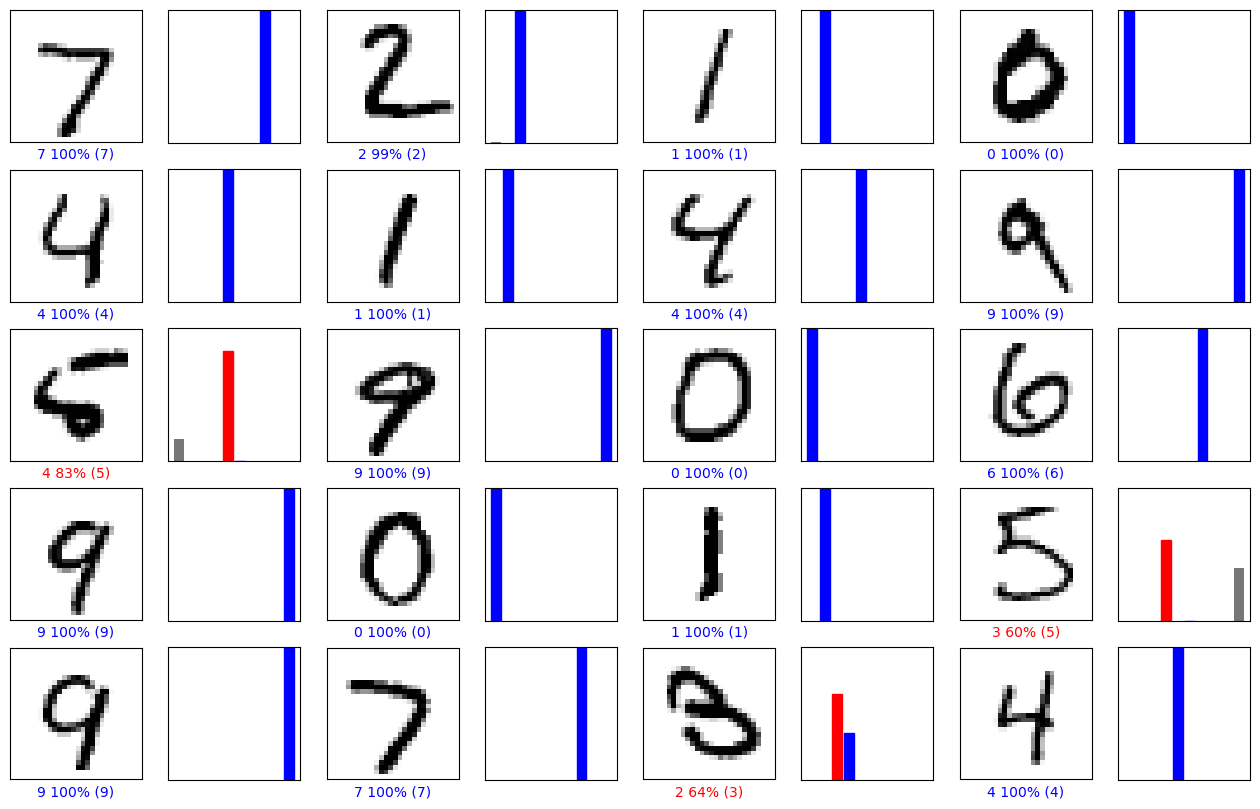

In [140]:
# Plots the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  mdl.lab2.plot_image_prediction(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  mdl.lab2.plot_value_prediction(i, predictions, test_labels)


## 1.4 Training the model 2.0

Earlier in the lab, we used the [`fit`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential#fit) function call to train the model. This function is quite high-level and intuitive, which is really useful for simpler models. As you may be able to tell, this function abstracts away many details in the training call, and we have less control over training model, which could be useful in other contexts.

As an alternative to this, we can use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) class to record differentiation operations during training, and then call the [`tf.GradientTape.gradient`](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient) function to actually compute the gradients. You may recall seeing this in Lab 1 Part 1, but let's take another look at this here.

We'll use this framework to train our `cnn_model` using stochastic gradient descent.

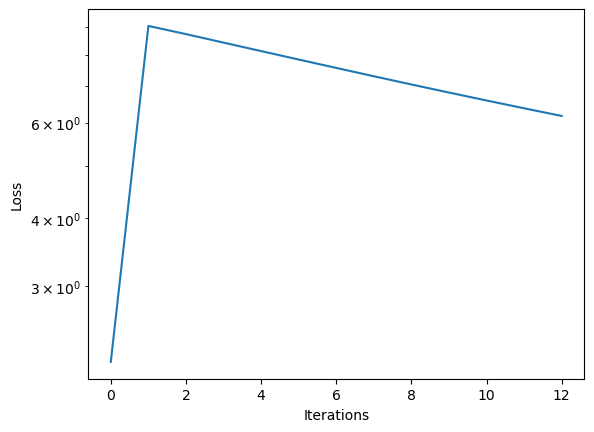

100%|██████████| 15/15 [00:02<00:00,  6.30it/s]


INFO:tensorflow:Assets written to: mnist_cnn2_training/assets


INFO:tensorflow:Assets written to: mnist_cnn2_training/assets


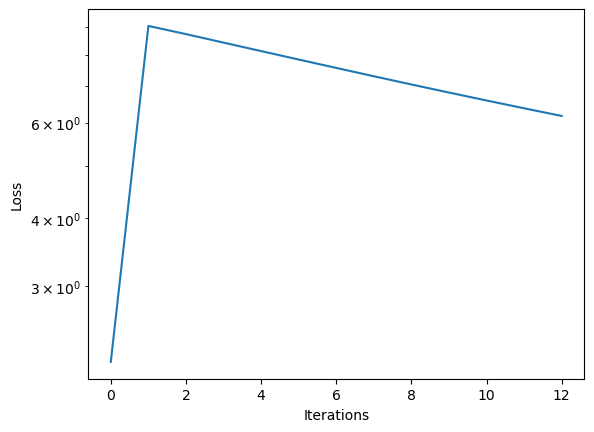

In [144]:
%load_ext tensorboard


model_directory = "mnist_cnn2_training/"
logs = os.path.join(model_directory, 'logs')
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = os.path.join(logs, 'gradient_tape', current_time, 'train')
test_log_dir = os.path.join(logs, 'gradient_tape', current_time, 'test')
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)


cp_callback, tensorboard_callback = persist_model(model_directory, logs)
callbacks = tf.keras.callbacks.CallbackList([cp_callback, tensorboard_callback])


def compute_loss(labels, logits):
  loss = tf.keras.backend.sparse_categorical_crossentropy(labels, logits, from_logits=True) # TODO
  train_loss(loss)
  return loss

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')

# Rebuild the CNN model
cnn_model = build_cnn_model()
batch_size = 4200
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=1e-3) # define our optimizer
cnn_model.compile(optimizer, compute_loss, metrics=[train_accuracy])

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
try:
    cnn_model.load_weights(model_directory)
except:
    pass

@tf.function
def train_step(x,y):
    with tf.GradientTape() as tape:
        logits = cnn_model(images)
        loss = compute_loss(labels, logits)
        train_accuracy(labels, logits)
        grads = tape.gradient(loss, cnn_model.trainable_variables) # TODO
        optimizer.apply_gradients(zip(grads, cnn_model.trainable_variables))
        return loss

steps=0
for idx in tqdm(range(0, train_images.shape[0], batch_size)):
    callbacks.on_batch_begin(idx)
# First grab a batch of training data and convert the input images to tensors
    (images, labels) = (train_images[idx:idx+batch_size], train_labels[idx:idx+batch_size])
    images = tf.convert_to_tensor(images, dtype=tf.float32)
    loss = train_step(images, labels)
    loss_history.append(loss.numpy().mean()) # append the loss to the loss_history record
    plotter.plot(loss_history.get())
    cnn_model.save_weights(model_directory)
    callbacks.on_batch_end(idx)
    steps+=1
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=idx)
        tf.summary.scalar('accuracy', train_accuracy.result(), step=idx)
cnn_model.save(model_directory)

with test_summary_writer.as_default():
    predictions = cnn_model(test_images)
    test_accuracy(test_labels, predictions)
    tf.summary.scalar('accuracy', test_accuracy.result(), step=idx)
train_summary_writer.flush()
test_summary_writer.flush()


In [145]:
'''TODO: Use the evaluate method to test the model!'''
test_loss, test_acc = cnn_model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

112/313 [=========>....................] - ETA: 0s - loss: 2.3010 - train_accuracy: 0.1122

/Users/ian/anaconda3/lib/python3.11/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 [==============================] - 0s 1ms/step - loss: 2.3017 - train_accuracy: 0.1135
Test accuracy: 0.11349999904632568


## 1.5 Conclusion
In this part of the lab, you had the chance to play with different MNIST classifiers with different architectures (fully-connected layers only, CNN), and experiment with how different hyperparameters affect accuracy (learning rate, etc.). The next part of the lab explores another application of CNNs, facial detection, and some drawbacks of AI systems in real world applications, like issues of bias.

In [146]:
print(f"Model accuracy {100*test_accuracy.result():.2f}%")

Model accuracy 11.35%


In [135]:
!rm -R mnist_acnn

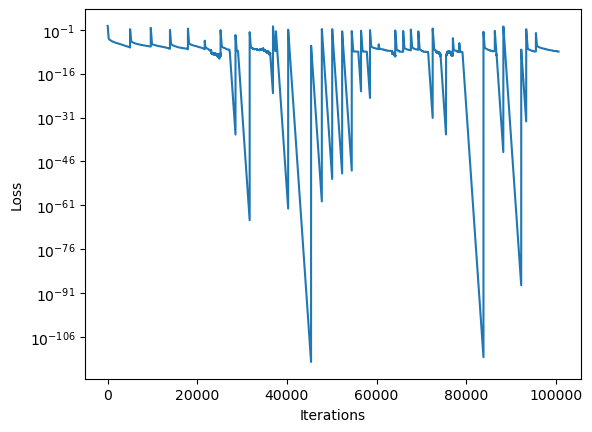

100%|██████████| 984/984 [00:04<00:00, 219.08it/s]


INFO:tensorflow:Assets written to: mnist_acnn/assets


INFO:tensorflow:Assets written to: mnist_acnn/assets


313/313 [==============================] - 0s 1ms/step - loss: 18.6719 - accuracy: 0.1129


[18.671934127807617, 0.11289999634027481]

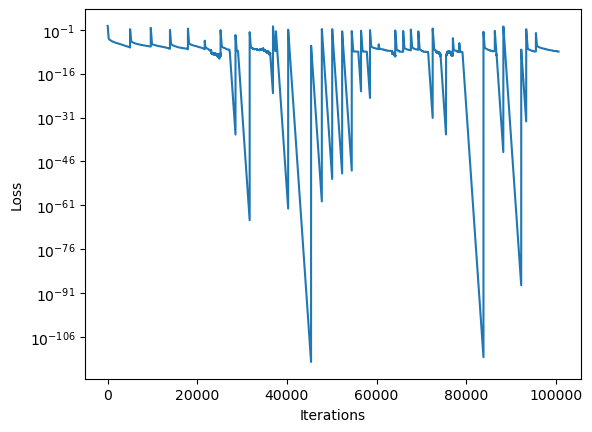

In [149]:
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

model_directory = "mnist_acnn/"
logs = os.path.join(model_directory, 'logs')
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = os.path.join(logs, 'gradient_tape', current_time, 'train')
test_log_dir = os.path.join(logs, 'gradient_tape', current_time, 'test')
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)


cp_callback, tensorboard_callback = persist_model(model_directory, logs)
callbacks = tf.keras.callbacks.CallbackList([cp_callback, tensorboard_callback])


atrain_loss = tf.keras.metrics.Mean(name='train_loss')
atrain_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
atest_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')

# Rebuild the CNN model
acnn_model = build_cnn_model()
batch_size = 12
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')


optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)


def compute_loss(labels, logits):
  loss = tf.keras.backend.sparse_categorical_crossentropy(labels, logits) # TODO
  atrain_loss(loss)
  return loss

acnn_model.compile(optimizer, compute_loss, metrics=['accuracy'])

# try:
#     acnn_model.load_weights(model_directory)
# except Exception as e:
#     print(e)

@tf.function
def train_step(x,y):
    with tf.GradientTape() as tape:
        logits = acnn_model(images)
        loss = compute_loss(labels, logits)
        atrain_accuracy(labels, logits)
        grads = tape.gradient(loss, acnn_model.trainable_variables) # TODO
        optimizer.apply_gradients(zip(grads, acnn_model.trainable_variables))
        return loss

steps=0

for epoch in range(0,50):
    for idx in tqdm(range(0, train_images.shape[0], batch_size+epoch)):
        callbacks.on_batch_begin(steps)
    # First grab a batch of training data and convert the input images to tensors
        (images, labels) = (train_images[idx:idx+batch_size+epoch], train_labels[idx:idx+batch_size+epoch])
        images = tf.convert_to_tensor(images, dtype=tf.float32)
        loss = train_step(images, labels)
        lmean = loss.numpy().mean()
        loss_history.append(lmean) # append the loss to the loss_history record
        plotter.plot(loss_history.get())
        # acnn_model.save_weights(model_directory)
        steps+=1
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', lmean, step=steps)
            tf.summary.scalar('train_accuracy', atrain_accuracy.result(), step=steps)
        callbacks.on_batch_end(steps)
    acnn_model.save(model_directory)

    with test_summary_writer.as_default():
        predictions = acnn_model(test_images)
        atest_accuracy(test_labels, predictions)
        tf.summary.scalar('test_accuracy', atest_accuracy.result(), step=steps)


    train_summary_writer.flush()
    test_summary_writer.flush()

acnn_model.evaluate(test_images, test_labels)

In [156]:
acnn_model.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 18.6719 - accuracy: 0.1129


[18.671934127807617, 0.11289999634027481]

In [150]:
print(f"Model accuracy {100*atest_accuracy.result():.2f}%")

Model accuracy 64.80%


In [151]:
test_labels, predictions

(array([7, 2, 1, ..., 4, 5, 6]),
 <tf.Tensor: shape=(10000, 10), dtype=float32, numpy=
 array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [2.7328451e-10, 0.0000000e+00, 5.1501372e-14, ..., 0.0000000e+00,
         4.0467790e-10, 2.9468979e-38],
        [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 1.0000000e+00],
        [1.5743183e-29, 0.0000000e+00, 0.0000000e+00, ..., 2.5330770e-37,
         2.9669800e-18, 9.9989963e-01],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32)>)

In [152]:
test_labels[0], predictions[0]

(7,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)>)

This is the solution given in the introtodeeplearning repo. I wanted to santity check my own poorer performance, albeit higher with signifigantly more training. 

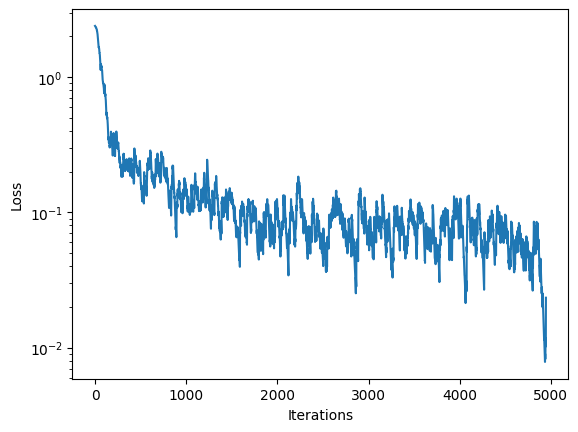

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 158.33it/s]


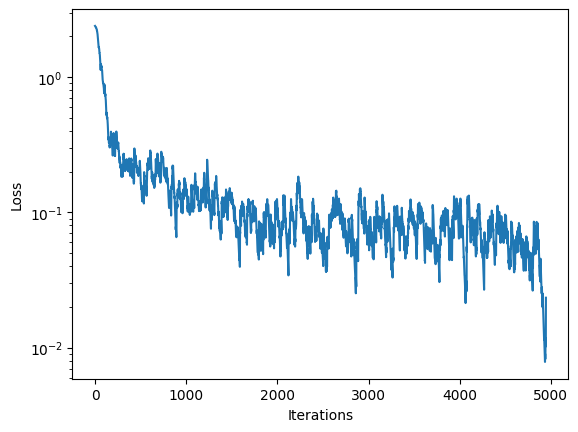

In [8]:
# Rebuild the CNN model
cnn_model = build_cnn_model()

batch_size = 12
loss_history = mdl.util.LossHistory(smoothing_factor=0.95) # to record the evolution of the loss
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss', scale='semilogy')
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2) # define our optimizer

if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for idx in tqdm(range(0, train_images.shape[0], batch_size)):
  # First grab a batch of training data and convert the input images to tensors
  (images, labels) = (train_images[idx:idx+batch_size], train_labels[idx:idx+batch_size])
  images = tf.convert_to_tensor(images, dtype=tf.float32)

  # GradientTape to record differentiation operations
  with tf.GradientTape() as tape:
    #'''TODO: feed the images into the model and obtain the predictions'''
    logits = cnn_model(images)
    # logits = # TODO

    #'''TODO: compute the categorical cross entropy loss
    loss_value = tf.keras.backend.sparse_categorical_crossentropy(labels, logits)
    # loss_value = tf.keras.backend.sparse_categorical_crossentropy('''TODO''', '''TODO''') # TODO

  loss_history.append(loss_value.numpy().mean()) # append the loss to the loss_history record
  plotter.plot(loss_history.get())

  # Backpropagation
  '''TODO: Use the tape to compute the gradient against all parameters in the CNN model.
      Use cnn_model.trainable_variables to access these parameters.''' 
  grads = tape.gradient(loss_value, cnn_model.trainable_variables)
  # grads = # TODO
  optimizer.apply_gradients(zip(grads, cnn_model.trainable_variables))


In [11]:
predictions = cnn_model.predict(test_images)

313/313 [==============================] - 0s 959us/step


In [19]:
test_labels[1000], predictions[1000]

(9,
 array([1.8792585e-04, 7.2714487e-05, 4.2775886e-05, 2.2373314e-03,
        4.7082067e-03, 1.0010824e-03, 3.3486918e-05, 4.9821637e-03,
        3.5178632e-04, 9.8638248e-01], dtype=float32))

In [15]:
cnn_model.compile(optimizer, tf.keras.backend.sparse_categorical_crossentropy)

In [16]:
cnn_model.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.0655


0.06547588855028152